In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

In [2]:
np.random.seed(0)

In this notebook, we test a simple implementation of Naive Bayes classifier for a categorical dataset. Naive Bayes is based on applying Bayes theorem and assumes independence between input variables. 

## Generate a categorical toy dataset

The toy dataset consists of two classes and three features. 

In [3]:
# First feature's likelihood
cond_probs_feat_a = pd.DataFrame(data = [[0.2, 0.1, 0.7],
                                         [0.5, 0.3, 0.2]], 
                                 columns = ['value_1', 'value_2', 'value_3'],
                                 index = ['class_a', 'class_b'])
cond_probs_feat_a

,value_1,value_2,value_3
class_a,0.2,0.1,0.7
class_b,0.5,0.3,0.2


In [4]:
# Second feature's likelihood
cond_probs_feat_b = pd.DataFrame(data = [[0.8, 0.2],
                                         [0.4, 0.6]], 
                                 columns = ['value_1', 'value_2'],
                                 index = ['class_a', 'class_b'])
cond_probs_feat_b

,value_1,value_2
class_a,0.8,0.2
class_b,0.4,0.6


In [5]:
# Third feature's likelihood
cond_probs_feat_c = pd.DataFrame(data = [[0.1, 0.2, 0.3, 0.4],
                                         [0.9, 0.02, 0.05, 0.03]], 
                                 columns = ['value_1', 'value_2', 'value_3', 'value_4'],
                                 index = ['class_a', 'class_b'])
cond_probs_feat_c

,value_1,value_2,value_3,value_4
class_a,0.1,0.20,0.30,0.40
class_b,0.9,0.02,0.05,0.03


In [6]:
# Class priors
prob_class = pd.Series([0.4, 0.6], index = ['class_a', 'class_b'])
prob_class

class_a    0.4
class_b    0.6
dtype: float64

In [7]:
# Randomly assigning observations to classes and assigning values to features given likelihoods
data = []
classes = []
for i in range(1000):
    observed = []
    # Sampling class label
    if np.random.rand() > prob_class.loc['class_a']:
        classes.append('class_b')
    else:
        classes.append('class_a')
    # Sampling features
    for cond_probs in [cond_probs_feat_a, cond_probs_feat_b, cond_probs_feat_c]:
        df = cond_probs.loc[classes[-1]].cumsum()
        observed.append(df[df > np.random.rand()].index.values[0])
    
    data.append(observed)

In [8]:
data = pd.DataFrame(data = data, columns = ['feature_a', 'feature_b', 'feature_c'])
data['class'] = classes
data.head()

,feature_a,feature_b,feature_c,class
0,value_2,value_2,value_1,class_b
1,value_2,value_2,value_1,class_b
2,value_1,value_2,value_1,class_b
3,value_3,value_1,value_1,class_b
4,value_3,value_1,value_4,class_a


## Visualise the data

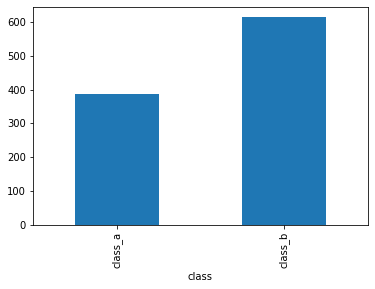

In [9]:
_ = data.groupby('class')['class'].count().plot.bar()

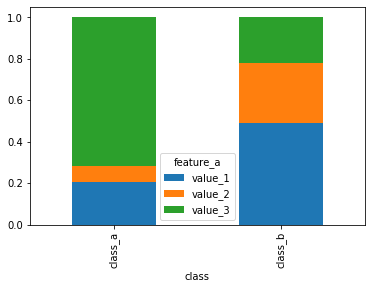

In [10]:
df = data.groupby(['class', 'feature_a'])['feature_a'].count().unstack('feature_a')
_ = df.div(df.sum(axis = 1), axis = 0).plot.bar(stacked = True)

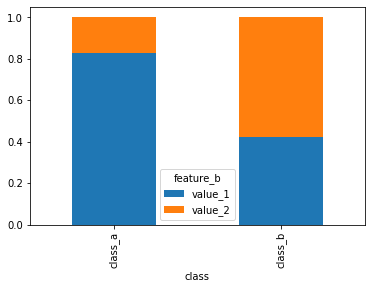

In [11]:
df = data.groupby(['class', 'feature_b'])['feature_b'].count().unstack('feature_b')
_ = df.div(df.sum(axis = 1), axis = 0).plot.bar(stacked = True)

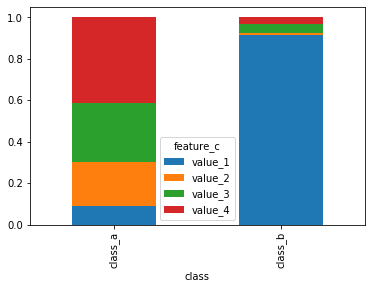

In [12]:
df = data.groupby(['class', 'feature_c'])['feature_c'].count().unstack('feature_c')
_ = df.div(df.sum(axis = 1), axis = 0).plot.bar(stacked = True)

The following visualisation, based on dimensionality reduction by means of MultiDimensional Scaling (MDS), is aimed at visually inspect the data and determine how much overlap there is between the classes i.e. whether the two classes can be easily separable. 

In [13]:
df = data.copy(deep = True)
for f in ['feature_a', 'feature_b', 'feature_c']:
    values = df[f].unique().tolist()
    for v in values:
        df[f + '_' + v] = (df[f] == v).astype(int)
    df = df.drop(f, axis = 1)

In [14]:
X = df.iloc[:, 1:].values
embedding = MDS(n_components = 2)
X_transformed = embedding.fit_transform(X)

In [15]:
X_transformed = X_transformed + np.random.rand(X_transformed.shape[0], X_transformed.shape[1]) * 0.5

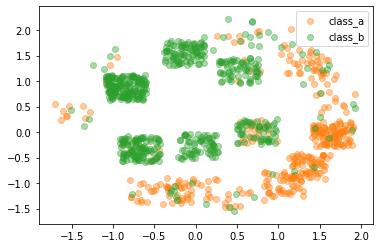

In [16]:
c_a = df[df['class'] == 'class_a'].index.values
c_b = df[df['class'] == 'class_b'].index.values
fig, ax = plt.subplots()
ax.scatter(X_transformed[c_a, 0], X_transformed[c_a, 1], alpha = 0.4, color = 'C1')
ax.scatter(X_transformed[c_b, 0], X_transformed[c_b, 1], alpha = 0.4, color = 'C2')
_ = ax.legend(['class_a', 'class_b'])

## Split into training/test set

We are assigning 80% of the data to the training set and 20% of the data to the test set. 

In [17]:
data = data.sample(frac = 1)
data.index = range(len(data))
df_training = data[0:math.ceil(0.8 * len(data))].copy()
df_test = data[math.ceil(0.8 * len(data)):].copy()

We are adding one more observation to the test set. This obsercation is assigned a value for the third feature (`value_5`) that was not observed during training. 

In [18]:
df_test.loc[len(data)] = ['value_1', 'value_1', 'value_5', 'class_b']
df_test

,feature_a,feature_b,feature_c,class
800,value_1,value_2,value_4,class_a
801,value_3,value_1,value_1,class_b
802,value_3,value_1,value_1,class_b
803,value_3,value_2,value_4,class_a
804,value_3,value_1,value_3,class_a
...,...,...,...,...
996,value_3,value_1,value_4,class_a
997,value_2,value_2,value_1,class_b
998,value_1,value_2,value_1,class_b
999,value_1,value_1,value_1,class_b


## Without laplacian smoothing

### Fit the model

In [19]:
# Estimate class priors from the training data
prior = df_training.groupby('class')['class'].count()
prior = prior / prior.sum()
prior

class
class_a    0.39875
class_b    0.60125
Name: class, dtype: float64

In [20]:
# Estimate first feature's likelihood from the training data 
likelihood_a = df_training.groupby(['class', 'feature_a'])['feature_a'].count()
likelihood_a = likelihood_a / likelihood_a.sum(level = 0)
likelihood_a

class    feature_a
class_a  value_1      0.200627
         value_2      0.084639
         value_3      0.714734
class_b  value_1      0.494802
         value_2      0.293139
         value_3      0.212058
Name: feature_a, dtype: float64

In [21]:
# Estimate second feature's likelihood from the training data
likelihood_b = df_training.groupby(['class', 'feature_b'])['feature_b'].count()
likelihood_b = likelihood_b / likelihood_b.sum(level = 0)
likelihood_b

class    feature_b
class_a  value_1      0.824451
         value_2      0.175549
class_b  value_1      0.411642
         value_2      0.588358
Name: feature_b, dtype: float64

In [22]:
# Estimate third deaeture's likelihood from the training data
# Manually assigning a likelihood of 0 for the value in the test data but not in the training data
likelihood_c = df_training.groupby(['class', 'feature_c'])['feature_c'].count()
likelihood_c = likelihood_c / likelihood_c.sum(level = 0)
likelihood_c['class_a', 'value_5'] = 0
likelihood_c['class_b', 'value_5'] = 0
likelihood_c.sort_index(inplace = True)
likelihood_c

class    feature_c
class_a  value_1      0.090909
         value_2      0.197492
         value_3      0.285266
         value_4      0.426332
         value_5      0.000000
class_b  value_1      0.914761
         value_2      0.014553
         value_3      0.039501
         value_4      0.031185
         value_5      0.000000
Name: feature_c, dtype: float64

### Predict test data

Using Bayes to calculate the class posteriors for each observation. Each observation is assigned to that class for which the posterior is maximum. 

In [23]:
df_test['posterior_a'] = df_test[['feature_a', 
                                  'feature_b', 
                                  'feature_c']].apply(lambda x: likelihood_a.loc['class_a', x[0]] * \
                                                                likelihood_b.loc['class_a', x[1]] * \
                                                                likelihood_c.loc['class_a', x[2]], 
                                                      axis = 1)


df_test['posterior_b'] = df_test[['feature_a', 
                                  'feature_b', 
                                  'feature_c']].apply(lambda x: likelihood_a.loc['class_b', x[0]] * \
                                                                likelihood_b.loc['class_b', x[1]] * \
                                                                likelihood_c.loc['class_b', x[2]], 
                                                      axis = 1)

df_test['pred_class'] = np.where(df_test['posterior_a'] >= df_test['posterior_b'], 'class_a', 'class_b')

In [24]:
accuracy = (df_test['pred_class'] == df_test['class']).sum() / len(df_test)
print('Prediction accuracy: ' + str(accuracy))

Prediction accuracy: 0.9253731343283582


In [25]:
confusion = [[(df_test[df_test['class'] == 'class_a']['pred_class'] == 'class_a').sum(),
              (df_test[df_test['class'] == 'class_a']['pred_class'] == 'class_b').sum()],
             [(df_test[df_test['class'] == 'class_b']['pred_class'] == 'class_a').sum(),
             (df_test[df_test['class'] == 'class_b']['pred_class'] == 'class_b').sum()]]
print('Confusion matrix:')
pd.DataFrame(data = confusion, columns = ['predicted a', 'predicted b'], index = ['class a', 'class b'])

Confusion matrix:


,predicted a,predicted b
class a,61,6
class b,9,125


Without Laplacian smoothing, any observation containing a value which was not observed during training (in this case, `value_5` in `feature_3`) will end up having a posterior value of zero for each class. Therefore, we will not be able to decide which class to assign to this observation. In our case, this observation was assigned `class_a` due to the way we treat draws. 

In [26]:
df_test.loc[len(data)][['posterior_a', 'posterior_b', 'class', 'pred_class']]

posterior_a          0
posterior_b          0
class          class_b
pred_class     class_a
Name: 1000, dtype: object

## Laplacian smoothing

The Laplacian smoothing variant introduces a smoothing parameter $\lambda$ which prevents observations with values not seen during training to be assigned a posterior of zero for every class. 

### Fit the model

In [27]:
LAMBDA = 1
K = 2 # Number of classes

In [28]:
# Estimate class priors from the training data
prior = df_training.groupby('class')['class'].count()
prior = (prior + LAMBDA) / (prior.sum() + K * LAMBDA)
prior

class
class_a    0.399002
class_b    0.600998
Name: class, dtype: float64

In [29]:
# Estimate first feature's likelihood from the training data 
A_a = len(df_training['feature_a'].unique().tolist())
likelihood_a = df_training.groupby(['class', 'feature_a'])['feature_a'].count()
likelihood_a = (likelihood_a + LAMBDA) / (likelihood_a.sum(level = 0) + A_a * LAMBDA)
likelihood_a

class    feature_a
class_a  value_1      0.201863
         value_2      0.086957
         value_3      0.711180
class_b  value_1      0.493802
         value_2      0.293388
         value_3      0.212810
Name: feature_a, dtype: float64

In [30]:
# Estimate second feature's likelihood from the training data 
A_b = len(df_training['feature_b'].unique().tolist())
likelihood_b = df_training.groupby(['class', 'feature_b'])['feature_b'].count()
likelihood_b = (likelihood_b + LAMBDA) / (likelihood_b.sum(level = 0) + A_b * LAMBDA)
likelihood_b

class    feature_b
class_a  value_1      0.822430
         value_2      0.177570
class_b  value_1      0.412008
         value_2      0.587992
Name: feature_b, dtype: float64

In [31]:
# Estimate third feature's likelihood from the training data 
A_c = len(df_test['feature_c'].unique().tolist())
likelihood_c = df_training.groupby(['class', 'feature_c'])['feature_c'].count()
likelihood_c_sum = likelihood_c.sum(level = 0)
likelihood_c = (likelihood_c + LAMBDA) 
likelihood_c['class_a', 'value_5'] = LAMBDA 
likelihood_c['class_b', 'value_5'] = LAMBDA
likelihood_c.sort_index(inplace = True)
likelihood_c = likelihood_c / (likelihood_c_sum + A_c * LAMBDA)
likelihood_c

class    feature_c
class_a  value_1      0.092593
         value_2      0.197531
         value_3      0.283951
         value_4      0.422840
         value_5      0.003086
class_b  value_1      0.907407
         value_2      0.016461
         value_3      0.041152
         value_4      0.032922
         value_5      0.002058
Name: feature_c, dtype: float64

### Predict test data

In [32]:
df_test['posterior_a'] = df_test[['feature_a', 
                                  'feature_b', 
                                  'feature_c']].apply(lambda x: likelihood_a.loc['class_a', x[0]] * \
                                                                likelihood_b.loc['class_a', x[1]] * \
                                                                likelihood_c.loc['class_a', x[2]], 
                                                      axis = 1)


df_test['posterior_b'] = df_test[['feature_a', 
                                  'feature_b', 
                                  'feature_c']].apply(lambda x: likelihood_a.loc['class_b', x[0]] * \
                                                                likelihood_b.loc['class_b', x[1]] * \
                                                                likelihood_c.loc['class_b', x[2]], 
                                                      axis = 1)

df_test['pred_class'] = np.where(df_test['posterior_a'] >= df_test['posterior_b'], 'class_a', 'class_b')

In [33]:
accuracy = (df_test['pred_class'] == df_test['class']).sum() / len(df_test)
print('Prediction accuracy: ' + str(accuracy))

Prediction accuracy: 0.9253731343283582


In [34]:
confusion = [[(df_test[df_test['class'] == 'class_a']['pred_class'] == 'class_a').sum(),
              (df_test[df_test['class'] == 'class_a']['pred_class'] == 'class_b').sum()],
             [(df_test[df_test['class'] == 'class_b']['pred_class'] == 'class_a').sum(),
             (df_test[df_test['class'] == 'class_b']['pred_class'] == 'class_b').sum()]]
print('Confusion matrix:')
pd.DataFrame(data = confusion, columns = ['predicted a', 'predicted b'], index = ['class a', 'class b'])

Confusion matrix:


,predicted a,predicted b
class a,61,6
class b,9,125


Even though this particular observation containing the unknown value for the third feature was still missclassified, at least we were able to prevent the algorithn to assign a value of zero to every single posterior. 

In [35]:
df_test.loc[len(data)][['posterior_a', 'posterior_b', 'class', 'pred_class']]

posterior_a    0.000512403
posterior_b    0.000418622
class              class_b
pred_class         class_a
Name: 1000, dtype: object